<a href="https://colab.research.google.com/github/Everysimo/DarkPattern_Thesis/blob/main/DarkPattern_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione Dark Pattern

## Ottenimento del dataset

In [ ]:
!pip install nltk
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from six.moves import urllib
from matplotlib import style
import missingno as msno
import pickle

style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (20,10)

DOWNLOAD_ROOT="https://raw.githubusercontent.com/Everysimo/DarkPattern_Thesis/main/dark-patterns-v2.csv"

#fetch del dataset da github
def fetch_file_data1(file_url1=DOWNLOAD_ROOT, file_path1="file"):
  os.makedirs(file_path1, exist_ok=True)
  csv_path1 = os.path.join(file_path1, "dataset.csv")
  urllib.request.urlretrieve(file_url1, csv_path1)
fetch_file_data1()

#df è la variabile che contiene il dataset
df=pd.read_csv("file/dataset.csv")
df=df[["Pattern String", "Comment", "Pattern Category", "Pattern Type", "Where in website?", "Deceptive?", "Website Page"]]
df.head(10)

,Pattern String,Comment,Pattern Category,Pattern Type,Where in website?,Deceptive?,Website Page
0,Collin P. from Grandview Missouri just bought ...,Periodic popup,Social Proof,Activity Notification,Product Page,No,https://alaindupetit.com/collections/all-suits...
1,"Faith in Glendale, United States purchased a C...",Periodic popup,Social Proof,Activity Notification,Product Page,No,https://bonescoffee.com/products/strawberry-ch...
2,Sharmeen Atif From Karachi just bought Stylish...,Periodic popup,Social Proof,Activity Notification,Product Page,No,https://brandsego.com/collections/under-rs-99/...
3,9 people are viewing this.,Product detail,Social Proof,Activity Notification,Product Page,No,https://brightechshop.com/products/ambience-so...
4,5338 people viewed this in the last hour,Periodic popup,Social Proof,Activity Notification,Product Page,No,https://bumpboxes.com/
5,"Keith in Champaign, Illinois bought Mini USB A...",Periodic popup,Social Proof,Activity Notification,Product Page,No,https://casettetomp3.com/products/mini-usb-aud...
6,Jamie from Eloy United States purchased a CBD ...,Periodic popup,Social Proof,Activity Notification,Product Page,No,https://cbdfx.com/products/og-kush-cbd-terpene...
7,"Someone in Kilwinning, United Kingdom just bou...",Periodic popup,Social Proof,Activity Notification,Product Page,No,https://chainedandable.com/collections/old-eng...
8,"Chelsea in Burlington, Wisconsin bought Take O...",Periodic popup,Social Proof,Activity Notification,Product Page,No,https://chicsoul.com/collections/new-arrivals/...
9,"Crystal Li in Flushing, United States purchased a",Periodic popup,Social Proof,Activity Notification,Product Page,No,https://cokodive.com/collections/kpop/products...


## 1) Data Cleaning

### 1.1) Descrizione del dataset

In [ ]:
#descrizione del dataset
df.describe()

,Pattern String,Comment,Pattern Category,Pattern Type,Where in website?,Deceptive?,Website Page
count,1512,1798,1818,1818,1818,1818,1818
unique,1178,371,7,15,5,3,1398
top,Only 1 left,Product detail,Scarcity,Low-stock Message,Product Page,No,https://fuzz.online/products/fg-grater
freq,26,684,679,632,1609,1584,11


### 1.2) Verifica valori null nel dataset

In [ ]:
#verifica se ci sono dati null nel dataset
df.isnull().any()
df.isnull().sum()

Pattern String       306
Comment               20
Pattern Category       0
Pattern Type           0
Where in website?      0
Deceptive?             0
Website Page           0
dtype: int64

In [ ]:
#verifica se ci sono dati NA nel dataset
df.isna().any()
df.isna().sum()

Pattern String       306
Comment               20
Pattern Category       0
Pattern Type           0
Where in website?      0
Deceptive?             0
Website Page           0
dtype: int64

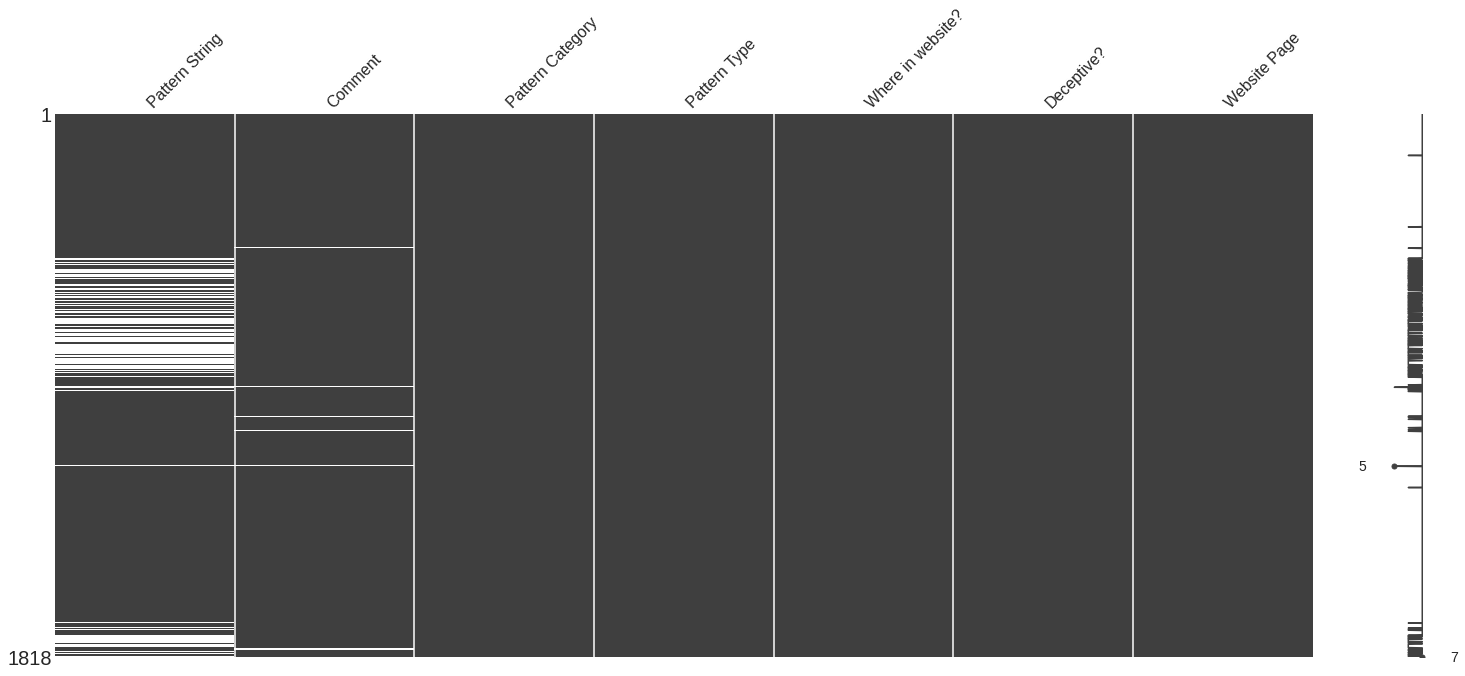

In [ ]:
%matplotlib inline
msno.matrix(df)

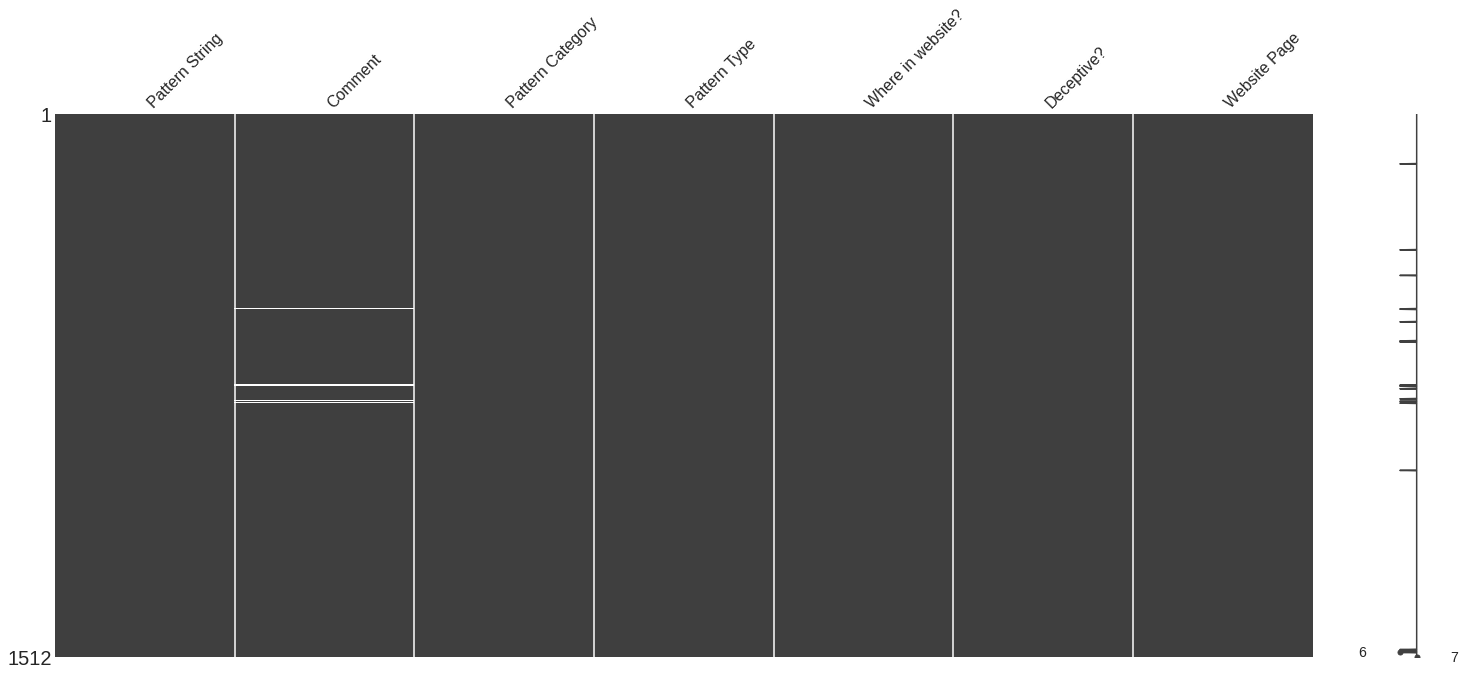

In [ ]:
df = df.dropna(subset=['Pattern String'])
%matplotlib inline
msno.matrix(df)

###1.3)Pre-Processing

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import re

nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("english")

df['Pattern String'] = df['Pattern String'].fillna('').apply(str)
df['Pattern String'] = df['Pattern String'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
df['Website Page'] = df['Website Page'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

df.head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Pattern String,Comment,Pattern Category,Pattern Type,Where in website?,Deceptive?,Website Page
0,collin p grandview missouri bought burgundi tw...,Periodic popup,Social Proof,Activity Notification,Product Page,No,http alaindupetit com collect suit product bla...
1,faith glendal unit state purchas choos your fl...,Periodic popup,Social Proof,Activity Notification,Product Page,No,http bonescoffe com product strawberri cheesec...
2,sharmeen atif from karachi bought stylish meta...,Periodic popup,Social Proof,Activity Notification,Product Page,No,http brandsego com collect rs product b n lip ...
3,peopl view,Product detail,Social Proof,Activity Notification,Product Page,No,http brightechshop com product ambienc solar w...
4,peopl view last hour,Periodic popup,Social Proof,Activity Notification,Product Page,No,http bumpbox com


## 2) Feature Selection

In [ ]:
df=df[["Pattern String", "Pattern Type"]]
df.head(10)
vectorizer = TfidfVectorizer(min_df= 3,stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df['Pattern String']).toarray()
final_features.shape

(1512, 465)

##3)Creazione Modelli

### RandomForestClassifier

In [ ]:
#Scelta variabile dipendente (y) e indipendenti (X)
X = df['Pattern String']
y = df['Pattern Type']

#per prima cosa dividiamo il dataset nel testing set e nel training set:
X_train, X_test, y_train, y_test = train_test_split(X, y)

from sklearn.model_selection import RepeatedKFold, KFold

#Kf con k gruppi
kf = KFold(random_state=42, shuffle=True)
#rkf con 3 gruppi e 10 ripetizioni per questioni della ram del coso
rkfRF = RepeatedKFold()

#Usiamo una Pipeline per automatizzare i vari setp
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=100)),
                     ('clf', RandomForestClassifier())])

#fittiamo il modello
model = pipeline.fit(X_train, y_train)

ytest = np.array(y_test)
# matrice di confusione e report della classificazione(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

                       precision    recall  f1-score   support

Activity Notification       0.79      0.97      0.87        76
       Confirmshaming       0.95      0.95      0.95        40
      Countdown Timer       0.88      0.86      0.87        35
       Hard to Cancel       0.86      1.00      0.92         6
         Hidden Costs       1.00      1.00      1.00         1
  Hidden Subscription       0.00      0.00      0.00         2
  High-demand Message       0.93      0.82      0.87        17
 Limited-time Message       0.95      0.83      0.88        23
    Low-stock Message       0.99      0.97      0.98       163
    Pressured Selling       0.40      0.20      0.27        10
    Sneak into Basket       0.00      0.00      0.00         1
      Trick Questions       0.00      0.00      0.00         1
  Visual Interference       0.00      0.00      0.00         3

             accuracy                           0.90       378
            macro avg       0.60      0.58      0.59 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

#Scelta variabile dipendente (y) e indipendenti (X)
X = df['Pattern String']
y = df['Pattern Type']

#per prima cosa dividiamo il dataset nel testing set e nel training set:
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Usiamo una Pipeline per automatizzare i vari setp
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=100)),
                     ('clf', MultinomialNB())])

#fittiamo il modello
model = pipeline.fit(X_train, y_train)

ytest = np.array(y_test)
# matrice di confusione e report della classificazione(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

                       precision    recall  f1-score   support

Activity Notification       0.91      0.86      0.89        72
       Confirmshaming       0.92      0.96      0.94        47
      Countdown Timer       0.93      0.77      0.84        35
    Forced Enrollment       0.00      0.00      0.00         1
       Hard to Cancel       1.00      0.80      0.89        10
         Hidden Costs       0.00      0.00      0.00         3
  Hidden Subscription       0.00      0.00      0.00         2
  High-demand Message       1.00      0.78      0.88         9
 Limited-time Message       0.78      0.90      0.84        20
    Low-stock Message       0.84      0.99      0.91       164
    Pressured Selling       1.00      0.12      0.22         8
    Sneak into Basket       0.00      0.00      0.00         1
      Trick Questions       0.00      0.00      0.00         1
  Visual Interference       0.00      0.00      0.00         5

             accuracy                           0.88 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#Scelta variabile dipendente (y) e indipendenti (X)
X = df['Pattern String']
y = df['Pattern Type']

#per prima cosa dividiamo il dataset nel testing set e nel training set:
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Usiamo una Pipeline per automatizzare i vari setp
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=100)),
                     ('clf', KNeighborsClassifier())])

#fittiamo il modello
model = pipeline.fit(X_train, y_train)

ytest = np.array(y_test)
# matrice di confusione e report della classificazione(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

                       precision    recall  f1-score   support

Activity Notification       0.81      0.98      0.89        90
       Confirmshaming       0.92      1.00      0.96        36
      Countdown Timer       0.84      0.78      0.81        40
    Forced Enrollment       0.00      0.00      0.00         1
       Hard to Cancel       0.91      1.00      0.95        10
         Hidden Costs       0.00      0.00      0.00         2
  Hidden Subscription       0.00      0.00      0.00         3
  High-demand Message       0.89      0.73      0.80        11
 Limited-time Message       0.89      0.94      0.91        17
    Low-stock Message       0.98      0.96      0.97       155
    Pressured Selling       0.67      0.20      0.31        10
    Sneak into Basket       0.00      0.00      0.00         1
  Visual Interference       0.00      0.00      0.00         2

             accuracy                           0.90       378
            macro avg       0.53      0.51      0.51 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LinearSVC

In [ ]:
from sklearn.svm import LinearSVC

#Scelta variabile dipendente (y) e indipendenti (X)
X = df['Pattern String']
y = df['Pattern Type']

#per prima cosa dividiamo il dataset nel testing set e nel training set:
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Usiamo una Pipeline per automatizzare i vari setp
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=100)),
                     ('linearsvc', LinearSVC())])

#fittiamo il modello
model = pipeline.fit(X_train, y_train)

ytest = np.array(y_test)
# matrice di confusione e report della classificazione(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

                       precision    recall  f1-score   support

Activity Notification       0.83      0.97      0.89        86
       Confirmshaming       0.94      0.98      0.96        45
      Countdown Timer       0.90      0.88      0.89        32
    Forced Enrollment       1.00      1.00      1.00         1
       Hard to Cancel       0.78      1.00      0.88         7
         Hidden Costs       0.00      0.00      0.00         2
  High-demand Message       1.00      0.92      0.96        13
 Limited-time Message       1.00      0.95      0.97        19
    Low-stock Message       0.99      0.99      0.99       156
    Pressured Selling       0.50      0.08      0.14        12
      Trick Questions       1.00      0.33      0.50         3
  Visual Interference       0.00      0.00      0.00         2

             accuracy                           0.93       378
            macro avg       0.74      0.67      0.68       378
         weighted avg       0.91      0.93      0.91 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
